<a href="https://colab.research.google.com/github/ricardoV94/ThinkBayesPymc3/blob/master/ThinkBayes_Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
pip install arviz

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [0]:
def custom_posterior_plots(trace):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    sns.kdeplot(trace['mu_m'], trace['sigma_m'], n_levels=5, cmap='Blues', ax=ax[0])
    plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
    sns.kdeplot(trace['mu_f'], trace['sigma_f'], n_levels=5, cmap='Blues', ax=ax[1])
    plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
    for axi in ax.ravel():
        axi.set_ylabel('Stddev (cm)')
        axi.set_xlabel('Mean height (cm)')
    ax[0].set_title('Posterior joint distribution - males')
    ax[1].set_title('Posterior joint distribution - females')
    plt.tight_layout()

    plt.figure()
    sns.kdeplot(trace['cv_m'], cumulative=True, label='male', lw=3 )
    sns.kdeplot(trace['cv_f'], cumulative=True, color='lightblue', label='female', lw=3)
    plt.xlabel('Coefficient of variation')
    plt.ylabel('Probability')

## 10.1 The Variability Hypothesis

In [0]:
# Load data
import pickle
from urllib.request import urlopen
d = pickle.load(urlopen("https://raw.githubusercontent.com/ricardoV94/ThinkBayesPymc3/master/data/variability_data.pkl")) 

In [5]:
np.mean(d[1]), np.mean(d[2])

(178.06622109101272, 163.22347500412215)

In [6]:
np.std(d[1]), np.std(d[2])

(7.723538444338627, 7.269142017824815)

In [7]:
np.std(d[1]) / np.mean(d[1]), np.std(d[2]) / np.mean(d[2])

(0.04337452885233631, 0.04453490539667309)

### 10.4 The posterior distribution of CV

In [0]:
def find_prior_range_mean(xs, num_stderrs=4):
    n = len(xs)
    m = np.mean(xs)
    s = np.std(xs)

    stderr_m = s / np.math.sqrt(n)
    spread_m = stderr_m * num_stderrs
    mu_range = [m - spread_m, m + spread_m]

    stderr_s = s / np.math.sqrt(2 * (n-1))
    spread_s = stderr_s * num_stderrs
    sigma_range = [s - spread_s, s + spread_s] 

    return mu_range, sigma_range

In [9]:
mu_range_m, sigma_range_m = find_prior_range_mean(d[1])
mu_range_f, sigma_range_f = find_prior_range_mean(d[2])

with pm.Model() as m_10_4:

    mu_m = pm.Uniform('mu_m', lower=mu_range_m[0], upper=mu_range_m[1])
    mu_f = pm.Uniform('mu_f', lower=mu_range_f[0], upper=mu_range_f[1])

    sigma_m = pm.Uniform('sigma_m', lower=sigma_range_m[0], upper=sigma_range_m[1])
    sigma_f = pm.Uniform('sigma_f', lower=sigma_range_f[0], upper=sigma_range_f[1])

    like_m = pm.Normal('like_m', mu=mu_m, sigma=sigma_m, observed=d[1])
    like_f = pm.Normal('like_f', mu=mu_f, sigma=sigma_f, observed=d[2])

    cv_m = pm.Deterministic('cv_m', sigma_m / mu_m)
    cv_f = pm.Deterministic('cv_f', sigma_f / mu_f)


    trace_m_10_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_f, sigma_m, mu_f, mu_m]
100%|██████████| 1500/1500 [00:48<00:00, 31.03it/s]


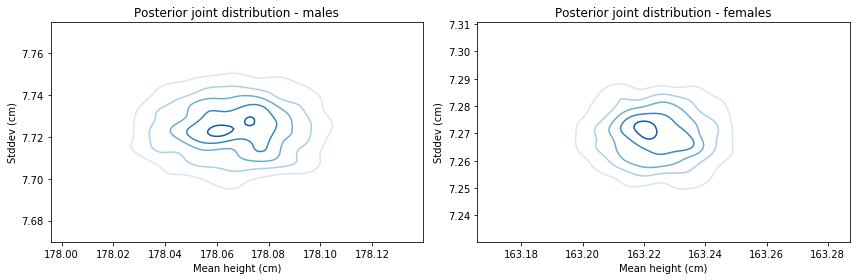

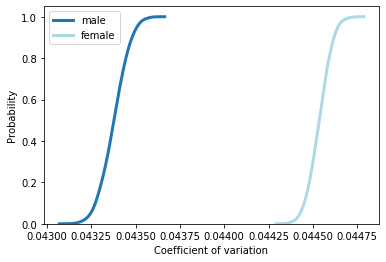

In [10]:
custom_posterior_plots(trace_m_10_4)

### 10.8 ABC (Approximate Bayesian Computation)

Faster inference based on likelihood of sample statistics and not of sample individual values. 

40x faster: from 25 it/s to 1000 it/s

In [11]:
mu_range_m, sigma_range_m = find_prior_range_mean(d[1])
mu_range_f, sigma_range_f = find_prior_range_mean(d[2])

n_m = len(d[1])
n_f = len(d[2])

with pm.Model() as m_10_8:

    mu_m = pm.Uniform('mu_m', lower=mu_range_m[0], upper=mu_range_m[1])
    mu_f = pm.Uniform('mu_f', lower=mu_range_f[0], upper=mu_range_f[1])

    sigma_m = pm.Uniform('sigma_m', lower=sigma_range_m[0], upper=sigma_range_m[1])
    sigma_f = pm.Uniform('sigma_f', lower=sigma_range_f[0], upper=sigma_range_f[1])

    stderr_mu_m = sigma_m / pm.math.sqrt(n_m)
    stderr_mu_f = sigma_f / pm.math.sqrt(n_f)
    like_mu_m = pm.Normal('like_mu_m', mu=mu_m, sigma=stderr_mu_m, observed=np.mean(d[1]))
    like_mu_f = pm.Normal('like_mu_f', mu=mu_f, sigma=stderr_mu_f, observed=np.mean(d[2]))

    stderr_sigma_m = sigma_m / pm.math.sqrt(2 * (n_m - 1))
    stderr_sigma_f = sigma_f / pm.math.sqrt(2 * (n_f - 1))
    like_sigma_m = pm.Normal('like_sigma_m', mu=sigma_m, sigma=stderr_sigma_m, observed=np.std(d[1]))
    like_sigma_f = pm.Normal('like_sigma_f', mu=sigma_f, sigma=stderr_sigma_f, observed=np.std(d[2]))


    cv_m = pm.Deterministic('cv_m', sigma_m / mu_m)
    cv_f = pm.Deterministic('cv_f', sigma_f / mu_f)


    trace_m_10_8 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_f, sigma_m, mu_f, mu_m]
100%|██████████| 5500/5500 [00:04<00:00, 1144.48it/s]


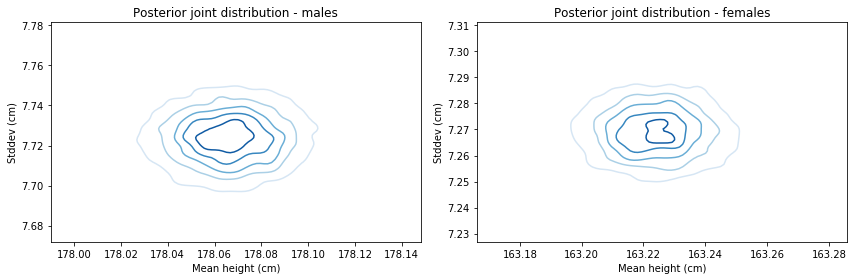

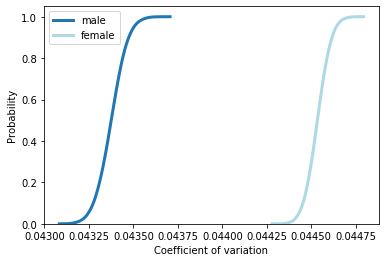

In [12]:
custom_posterior_plots(trace_m_10_8)

### 10.9 Robust estimation

Note: Results and conclusions are different from book. Females are more similar with num_sigmas = 1, and less with num_sigmas = 2. Possible bug?

In [0]:
def median_ipr(xs, p):
    median = np.median(xs)

    alpha = (100-p) / 2
    percentile = np.percentile(xs, q=[alpha, 100-alpha])
    ipr = percentile[1] - percentile[0]

    return median, ipr

def median_sigma(xs, num_sigmas):
    half_p = st.norm().cdf(num_sigmas) - 0.5

    median, ipr = median_ipr(xs, half_p * 2 * 100)
    sigma = ipr / 2 / num_sigmas

    return median, sigma

In [0]:
def find_prior_range_median(xs, num_sigmas, num_stderrs=4):
    n = len(xs)
    m, s = median_sigma(xs, num_sigmas)

    stderr_m = s / np.math.sqrt(n)
    spread_m = stderr_m * num_stderrs
    mu_range = [m - spread_m, m + spread_m]

    stderr_s = s / np.math.sqrt(2 * (n-1))
    spread_s = stderr_s * num_stderrs
    sigma_range = [s - spread_s, s + spread_s] 

    return mu_range, sigma_range

In [0]:
def create_model_10_9(num_sigmas):
    with pm.Model() as m_10_9:

        # Extract sample estimates
        mu_range_m, sigma_range_m = find_prior_range_median(d[1], num_sigmas)
        mu_range_f, sigma_range_f = find_prior_range_median(d[2], num_sigmas)

        sample_median_m, sample_sigma_m = median_sigma(d[1], num_sigmas)
        sample_median_f, sample_sigma_f = median_sigma(d[2], num_sigmas)

        n_m = len(d[1])
        n_f = len(d[2])

        # Model
        mu_m = pm.Uniform('mu_m', lower=mu_range_m[0], upper=mu_range_m[1])
        mu_f = pm.Uniform('mu_f', lower=mu_range_f[0], upper=mu_range_f[1])

        sigma_m = pm.Uniform('sigma_m', lower=sigma_range_m[0], upper=sigma_range_m[1])
        sigma_f = pm.Uniform('sigma_f', lower=sigma_range_f[0], upper=sigma_range_f[1])

        stderr_mu_m = sigma_m / pm.math.sqrt(n_m)
        stderr_mu_f = sigma_f / pm.math.sqrt(n_f)
        like_mu_m = pm.Normal('like_mu_m', mu=mu_m, sigma=stderr_mu_m, observed=sample_median_m)
        like_mu_f = pm.Normal('like_mu_f', mu=mu_f, sigma=stderr_mu_f, observed=sample_median_f)

        stderr_sigma_m = sigma_m / pm.math.sqrt(2 * (n_m - 1))
        stderr_sigma_f = sigma_f / pm.math.sqrt(2 * (n_f - 1))
        like_sigma_m = pm.Normal('like_sigma_m', mu=sigma_m, sigma=stderr_sigma_m, observed=sample_sigma_m)
        like_sigma_f = pm.Normal('like_sigma_f', mu=sigma_f, sigma=stderr_sigma_f, observed=sample_sigma_f)

        cv_m = pm.Deterministic('cv_m', sigma_m / mu_m)
        cv_f = pm.Deterministic('cv_f', sigma_f / mu_f)

    return m_10_9

In [16]:
traces_m_10_9 = []
for num_sigmas in (1, 2):
    with create_model_10_9(num_sigmas):
        traces_m_10_9.append(pm.sample(5000, progressbar=False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_f, sigma_m, mu_f, mu_m]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_f, sigma_m, mu_f, mu_m]


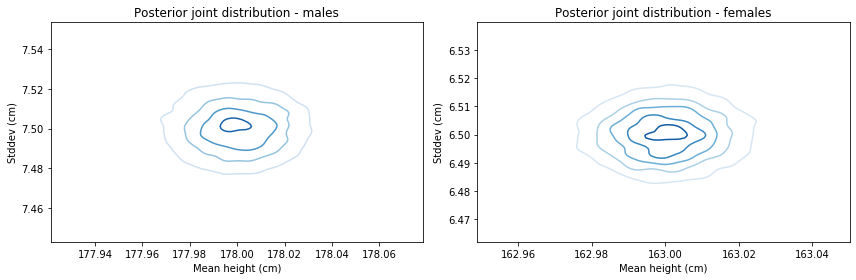

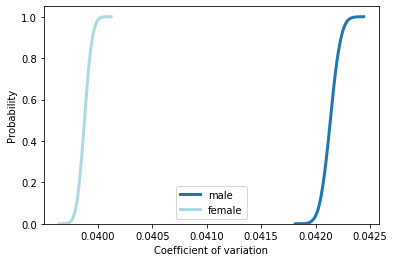

In [17]:
custom_posterior_plots(traces_m_10_9[0])

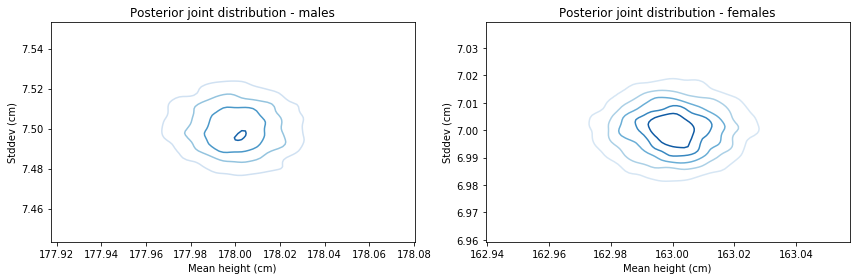

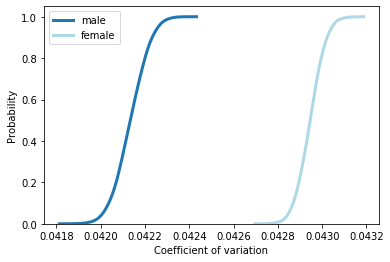

In [18]:
custom_posterior_plots(traces_m_10_9[1])